In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

%reload_ext autoreload
%autoreload 2

## Carga del mockup dataset

In [2]:
df = pd.read_csv('simulated_data_2.csv')

In [3]:
df

,customer_id,age,gender,income_bracket,region,household_size,tenure,payment_history,monthly_consumption,customer_satisfaction_score,complaints_last_year,churn_risk_score,flag_unsatisfied,treatment,effect,churn_prob,churned,post_intervention_satisfaction
0,0,45.960570,M,bajo,urbano,2,8.005516,1,48.858802,5.221074,4,0.109862,1,0,0.3,0.109862,0,5.443736
1,1,38.340828,M,medio,urbano,3,6.450702,0,56.754625,6.088374,0,0.158069,0,1,0.3,0.110648,0,6.773708
2,2,47.772262,M,alto,urbano,2,7.502395,1,70.299616,6.890282,2,0.052697,0,1,0.3,0.036888,0,7.924775
3,3,58.276358,M,medio,urbano,1,11.838634,1,55.603568,5.125064,1,0.071723,0,0,0.3,0.071723,0,5.303160
4,4,37.190160,F,bajo,urbano,2,6.836628,0,47.798866,7.249211,1,0.064875,0,1,0.3,0.045413,0,8.065166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,55.613225,F,medio,urbano,4,5.085338,0,75.055422,5.735858,0,0.190032,1,1,0.3,0.133023,0,6.607153
9996,9996,18.000000,F,medio,urbano,4,0.630427,3,62.622381,3.665672,7,0.606405,0,0,0.2,0.606405,0,3.436760
9997,9997,31.536199,M,medio,rural,3,7.375893,2,58.757085,6.775811,2,0.175365,0,1,0.3,0.122756,0,7.216436
9998,9998,45.949187,F,medio,urbano,2,6.614678,1,45.539655,4.503459,5,0.578835,0,0,0.2,0.578835,0,4.137695


## Propensity Scores with stratification

A continuación tienes un ejemplo práctico en Python que muestra cómo, tras cargar el mock dataset, podemos estimar el efecto causal de la intervención (*treatment*) sobre la variable de resultado (*churned*) mediante **propensity scores con estratificación**. Además, calcularemos tres estimadores de interés: **ATE** (*Average Treatment Effect*), **ATT** (*Average Treatment Effect on the Treated*) y **ATU** (*Average Treatment Effect on the Untreated*).

In [5]:
# -----------------------------------------------------------------------------
# 1. Supongamos que df es el mock dataset generado con las variables siguientes:
#
# df.columns -> [
#   'customer_id', 'age', 'gender', 'income_bracket', 'region',
#   'household_size', 'tenure', 'payment_history', 'monthly_consumption',
#   'customer_satisfaction_score', 'complaints_last_year', 'churn_risk_score',
#   'flag_unsatisfied', 'treatment', 'churned', 'post_intervention_satisfaction'
# ]
#
# Si no lo has generado, descomenta y ejecuta la simulación anterior,
# luego continúa desde aquí.
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# 2. Ajustar el modelo de Propensity Score (PS)
# -----------------------------------------------------------------------------
# Usamos una regresión logística para estimar p(treatment=1 | X).
# Elegimos como covariables X aquellas que consideramos confounders o
# determinantes de la asignación al tratamiento. Ajusta según tu criterio.

# Definimos una fórmula de ejemplo. Usamos C() para variables categóricas.
# Nota: 'churn_risk_score' también podría incluirse (o no) según tu escenario.
formula_ps = """
treatment ~ age + C(income_bracket) + C(region) + household_size
           + tenure + payment_history + monthly_consumption
           + customer_satisfaction_score + complaints_last_year + churn_risk_score
"""

# Ajustamos el modelo logístico
ps_model = smf.logit(formula_ps, data=df).fit(disp=0)
df['pscore'] = ps_model.predict(df)

# -----------------------------------------------------------------------------
# 3. Crear estratos (bins) basados en el Propensity Score
# -----------------------------------------------------------------------------
# Dividimos los clientes en 5 estratos (quintiles) según el valor de pscore.
# Se puede usar 5, 10 estratos o incluso un método de tamaño óptimo.
df['strata'] = pd.qcut(df['pscore'], q=5, labels=False)  # 0,1,2,3,4

# -----------------------------------------------------------------------------
# 4. Calcular la diferencia de medias en cada estrato y los pesos para ATE
# -----------------------------------------------------------------------------
# Para cada estrato s, calculamos:
# - Y1s: media de 'churned' en tratados
# - Y0s: media de 'churned' en no tratados
# - Ns: número total de individuos en estrato s
# - Ns1: número de tratados en estrato s
# - Ns0: número de no tratados en estrato s

# Luego la diferencia de medias en cada estrato s = (Y1s - Y0s).

# El ATE se estima como la media ponderada de las diferencias de cada estrato,
# ponderando por el tamaño de cada estrato (Ns/N).
# ATT se pondera por la proporción de tratados en cada estrato (Ns1/N1).
# ATU se pondera por la proporción de no tratados en cada estrato (Ns0/N0).

strata_results = []
N = len(df)
N1 = df['treatment'].sum()      # total tratados
N0 = N - N1                     # total no tratados

for s in sorted(df['strata'].unique()):
    subset = df[df['strata'] == s]
    Ns = len(subset)
    Ns1 = subset['treatment'].sum()
    Ns0 = Ns - Ns1

    # Medias de churn en tratados y no tratados
    Y1s = subset.loc[subset['treatment'] == 1, 'churned'].mean()
    Y0s = subset.loc[subset['treatment'] == 0, 'churned'].mean()

    # Diferencia en ese estrato
    diff_s = (Y1s - Y0s)

    # Guardamos info para el cómputo global
    strata_results.append({
        'strata': s,
        'Ns': Ns,
        'Ns1': Ns1,
        'Ns0': Ns0,
        'Y1s': Y1s,
        'Y0s': Y0s,
        'diff_s': diff_s
    })

# Convertimos a DataFrame para facilitar cálculos
strata_df = pd.DataFrame(strata_results)

# ATE: promedio ponderado por Ns / N
strata_df['weight_ATE'] = strata_df['Ns'] / N
strata_df['contrib_ATE'] = strata_df['diff_s'] * strata_df['weight_ATE']
ATE_strat = strata_df['contrib_ATE'].sum()

# ATT: promedio ponderado por Ns1 / N1
strata_df['weight_ATT'] = strata_df['Ns1'] / N1
strata_df['contrib_ATT'] = strata_df['diff_s'] * strata_df['weight_ATT']
ATT_strat = strata_df['contrib_ATT'].sum()

# ATU: promedio ponderado por Ns0 / N0
strata_df['weight_ATU'] = strata_df['Ns0'] / N0
strata_df['contrib_ATU'] = strata_df['diff_s'] * strata_df['weight_ATU']
ATU_strat = strata_df['contrib_ATU'].sum()

# -----------------------------------------------------------------------------
# 5. Mostramos resultados
# -----------------------------------------------------------------------------
print("Resultados por estrato (quintil de PS):")
print(strata_df[['strata','Ns','Ns1','Ns0','Y1s','Y0s','diff_s',
                 'weight_ATE','contrib_ATE']])

print(f"\nATE (estratificación PS): {ATE_strat:.4f}")
print(f"ATT (estratificación PS): {ATT_strat:.4f}")
print(f"ATU (estratificación PS): {ATU_strat:.4f}")


Resultados por estrato (quintil de PS):
   strata    Ns  Ns1   Ns0       Y1s       Y0s    diff_s  weight_ATE  \
0       0  2000  535  1465  0.052336  0.070307 -0.017971         0.2   
1       1  2000  569  1431  0.079086  0.124389 -0.045302         0.2   
2       2  2000  670  1330  0.138806  0.193985 -0.055179         0.2   
3       3  2000  698  1302  0.212034  0.283410 -0.071376         0.2   
4       4  2000  843  1157  0.393832  0.528954 -0.135123         0.2   

   contrib_ATE  
0    -0.003594  
1    -0.009060  
2    -0.011036  
3    -0.014275  
4    -0.027025  

ATE (estratificación PS): -0.0650
ATT (estratificación PS): -0.0712
ATU (estratificación PS): -0.0619


### Explicación de la estimación

1. Propensity Score Model

+ Ajustamos un modelo logístico para estimar $\hat{p}_i = P(treatment_i = 1 | X_i)$, es decir, la probabilidad de recibir el tratamiento dado las covariables.
+ Esto nos da, para cada cliente, la probabilidad (predicha) de recibir el tratamiento dado sus covariables.

2. Estratificación

+ Se agrupan los clientes en varios estratos (bins) según su $\hat{p}_i$. Aquí usamos 5 (quintiles).
+ Dentro de cada estrato, la distribución de las covariables se supone más homogénea entre tratados y no tratados, reduciendo el sesgo por confusión.

3. Diferencia de medias en cada estrato

+ Para cada estrato $s$, calculamos la media del outcome (churned) entre tratados ($Y_{1s}$) y no tratados ($Y_{0s}$). 
+ La diferencia $\Delta_s = Y_{1s} - Y_{0s}$ es una estimación local del efecto.

4. Combinar estratos

+ Para el ATE, ponderamos cada  $\Delta_s$ por la proporción de individuos de ese estrato, $\frac{N_s}{N}$, y sumamos:

$$
\hat{\text{ATE}} = \sum_{s=1}^{S} (\Delta_s \times \frac{N_s}{N})
$$

+ Para el ATT, ponderamos cada $\Delta_s$ por la fracción de tratados en el estrato respecto al total de tratados, $\frac{N_{s1}}{N_1}$.

$$
\hat{\text{ATT}} = \sum_{s=1}^{S} (\Delta_s \times \frac{N_{s1}}{N_1})
$$

+ Para el ATU, se hace algo análogo con la fracción de no tratados en cada estrato.

Este procedimiento es uno de los métodos clásicos de ajuste por PS y permite aislar (aproximadamente) el efecto causal de la intervención siempre que tengamos la hipótesis de unconfoundedness (todas las variables relevantes para la asignación y outcome estén en X) y un buen solapamiento en los valores de $\hat{p}_i$ entre tratados y no tratados.

### Interpretación final
+ ATE (Average Treatment Effect) nos da la estimación del efecto medio de la intervención sobre la población completa (todos los clientes).
+ ATT (Average Treatment effect on the Treated) mide el efecto promedio entre quienes realmente recibieron el tratamiento.
+ ATU (Average Treatment effect on the Untreated) mide el efecto promedio entre quienes no fueron tratados (hipotéticamente, si lo hubieran sido).

Con este flujo de trabajo (propensity scores + estratificación) logramos una estimación no paramétrica relativamente transparente del efecto causal, cumpliendo con las condiciones habituales de la metodología de propensity score.

Analyzing strata outcomes

I examined the user results across different strata, noting that no treated group existed for stratum 0, leading to NaN values for Y1s, Y0s, and diff_s.

Evaluating churn rates

Interestingly enough, stratum 1 reveals that only one treated individual churned, which is astonishingly high. This trend is continuing, showing higher churn rates for treated groups in the subsequent stratum.

Monitoring churn rates

Hm, that's interesting—churn rates are consistently higher for treated groups across all strata, with a notable ATE of 0.3154, suggesting a 31.54 percentage point increase in churn for treated individuals.

Analyzing churn dynamics

The expected negative effect on churn rates is notably absent. Interestingly, treated groups consistently exhibit higher churn rates, which could suggest data or analysis issues.

Reassessing the data

Interestingly, the findings suggest a discrepancy in the expected outcome. The significant positive effect might indicate data or interpretation errors, such as a reversible churn indicator.

Evaluating data quality

OK, let me see. The data might have overfitting issues, mismatched signs, or high-risk induced treatment effects. Reversing the logic in the code could also be responsible.

Analyzing churn dynamics

Investigating the treatment effect on churn shows that the treated group churns more, possibly due to selection bias or a risk that overrides the treatment's benefits.

Assessing treatment effect

I'm piecing together the results: a 31.54 percentage point higher churn rate for treated groups, and a 10.69 percentage point higher churn rate for those actually treated.

Spotting data trends

Interestingly, the treated group churns more, which could be due to poor data control or a mismatch between observed and expected outcomes.

Evaluating data impact

Small sample sizes for treated groups, like 1 or 2, can significantly skew results, potentially inflating overall effects and leading to weighted inaccuracies in the analysis.

Examining boundaries

Interestingly enough, the ATU of 0.3246 is the largest difference, suggesting that the net effect could be hidden or overpowered by other factors.

Sorting out treatment effects

It's interesting to see that the large difference in the second stratum likely stems from not enough overlap in propensity scores, with the majority of treatment concentrated in the last stratum.

Spotting potential errors

The results show an unexpected positive difference. This could imply a coding mistake in outcome generation or a mix-up in reversing the churn outcome codes between 0 and 1.

Reflecting on churn risk

A 31.54% churn probability increase suggests that treatment might be linked with higher churn rates, possibly due to a selection bias or inadequate model overlap.

Addressing data gaps

The treated group shows high risk with limited overlap, leading to a potentially flawed estimate. This highlights the need for careful data management and model adjustments.

Reassessing assumptions

OK, let me see. The positive sign indicates the churn rate is higher in the treated group, possibly due to baseline risk differences or selection bias.

Pinpointing the issue

It seems the positive churn difference might stem from insufficient overlap or a coding error, especially due to the tiny sample size in the first strata.

Reevaluating the results

OK, let me see. The higher churn rate in the treated group might stem from a small sample size in the low-propensity strata, leading to a misleading positive difference.

Understanding potential bias

The positive churn difference for the treated group might be due to the low-propensity strata's tiny sample size, leading to an inflated and potentially misleading result.

Evaluating strata impact

OK, let me see. Small sample sizes in low-propensity strata can skew the results. Considering merging, removal, or new approaches like matching or weighting could mitigate this.

Investigating potential issues

I'm looking into whether small sample sizes or the absence of overlap in propensity score distributions might distort results, possibly leading to misleading conclusions.

Assessing stratification

Given the absence of overlap in propensity score distributions, there might be misleading positive effects. It might be wise to merge strata with few treated samples.

Assessing data validity

It seems the sparse data in the last stratum is significantly influencing the results, leading to a seemingly positive treatment effect that might not reflect the actual scenario.

Investigating weak outcomes

I’m thinking through the low effect size and potential coding errors that might distort results. Additionally, persistent confounding suggests the need for better risk factor control in the stratified analysis.

A simple vista, los números resultantes parecen contradictorios respecto a la lógica original de la simulación (donde el tratamiento debía reducir el churn). Veamos primero qué significan y por qué puede salir un efecto positivo en lugar de negativo.

1. Observando los resultados concretos
Te han salido los siguientes valores (vía estratificación por PS):

ATE = 0.3154
ATT = 0.1069
ATU = 0.3246
Interpretación “directa”:

El ATE ≈ 0.3154 indica que, según esta estimación, haber recibido tratamiento se asocia con un +31.54 puntos porcentuales de churn en promedio sobre toda la población.
El ATT ≈ 0.1069 indica que, entre los efectivamente tratados, el tratamiento se asocia con +10.69 puntos porcentuales de churn.
El ATU ≈ 0.3246 indica que, entre los no tratados, si hipotéticamente hubieran sido tratados, el churn subiría 32.46 puntos porcentuales.
Es decir, el método está arrojando que el tratamiento aumenta el churn (un efecto positivo en la diferencia Tratado - No tratado). Esto contradice nuestro código de generación, donde pusimos:

python
Copy
Edit
treatment_effect = 0.2  # reduce la prob de churn en un 20%
churn_prob[treatment == 1] *= (1 - treatment_effect)
…lo que, en teoría, debería bajar la probabilidad de churn en el grupo tratado.

2. Por qué pasa: vistazo a la tabla por estratos
La tabla de estratificación también aporta pistas:

yaml
Copy
Edit
strata    Ns  Ns1   Ns0    Y1s      Y0s    diff_s (Y1s - Y0s)
0         2000  0   2000   NaN      0.049   NaN
1         2000  1   1999   1.000    0.071   0.928964
2         2000  2   1998   0.500    0.1186  0.381381
3         2000  58  1942   0.362    0.188   0.174118
4         2000  362 1638   0.464    0.372   0.092294
Observa:

En stratum 0 (la gente con propensity score más bajo), hay 0 tratados. No podemos calcular diferencia.
En stratum 1, hay 1 solo individuo tratado, que churnea al 100% (Y1s=1.0), mientras que los 1999 no tratados tienen churn ≈ 0.071. La diferencia es +0.93.
En stratum 2, solo 2 tratados, con churn medio=0.50. Los 1998 no tratados tienen churn=0.1186. La diferencia es +0.38.
En stratum 3 y 4 hay más tratados, y en ambos casos el churn de los tratados es más alto que el de los no tratados.
De esos números se deriva una diferencia global positiva, y por eso la ATE acaba siendo +0.3154.

3. Qué sugiere este resultado
Falta de solapamiento (overlap) en los PS:

Observa cómo en los estratos de menor propensity score (0, 1, 2), casi nadie recibe tratamiento (0, 1 o 2 personas). Eso crea estimaciones muy inestables en esos estratos.
En la vida real, cuando hay estratos enteros con casi ningún tratado (o al revés, casi ningún no tratado), el método de estratificación se vuelve poco confiable.
El tratamiento está muy concentrado en estratos altos (3 y 4).

Sin embargo, aun en el estrato más alto (stratum 4) aparece un churn del 0.464 en tratados vs. 0.372 en no tratados → diferencia +0.092. Es decir, aun en la zona de mayor propensity, la tasa de churn del grupo tratado supera la del no tratado.
¿Efecto negativo “oculto” por confounding residual?

En la simulación, quienes reciben tratamiento suelen ser muy de alto riesgo (basado en churn_risk_score).
Si ese “alto riesgo” no está perfectamente recogido en el propensity score (o si queda confounding sin modelar), podemos terminar con un sesgo que hace que, incluso tras la estratificación, el churn medio de los tratados aparezca más alto que el de los no tratados.
Tamaño diminuto de tratados en algunos estratos genera cifras extremas.

Stratum 1: 1 tratado que churnea = 100% → +0.93 de diferencia.
Esto, multiplicado por su peso (0.2 en la contribución al ATE), ya añade +0.186 a la ATE final.
¡Sólo un individuo con churn=1 en un estrato afecta un 18.6% a la estimación del ATE!
4. Coherencia (o no) con el diseño de la simulación
En el script original, el tratamiento debía reducir la probabilidad de churn. Sin embargo, estamos viendo lo contrario. Posibles explicaciones:

Poca capacidad de la estratificación para compensar la fortísima selección al tratamiento.

Podría hacer falta más estratos, o agrupar estratos con muy pocos tratados.
O, más usual: usar otras técnicas (matching, IPW, trimming de PS, etc.) para mejorar el balance.
El “efecto 20% de reducción” no basta para compensar la altísima diferencia de riesgo subyacente.

Imagina un cliente con churn_prob base de 0.90; con tratamiento pasaría a 0.72, que sigue siendo mayor que el 0.30 de otro cliente sin tratamiento. A pesar de la mejora individual, en promedio el grupo tratado (de altísimo riesgo) puede mantener un churn superior.
Así, la estratificación sigue comparando un puñado de casos de alto riesgo (tratados) contra una mayoría de casos de riesgo menor (no tratados). El resultado neto parece “el tratamiento produce más churn”, cuando en realidad lo que pasa es que “los tratados eran mucho peores de partida”.
Posible error de codificación (revisar sign o definiciones).

A veces se confunde churn=1 con “retained=1”. Asegúrate de que 1 signifique “fuga” y no al revés.
Revisa que el treatment_effect se haya aplicado correctamente.
Muestras muy pequeñas en los estratos inferiores

Ese 1 caso tratado en stratum 1 que churnea = 100% → sube mucho el ATE por la forma en que se hace la ponderación estrato a estrato.
5. ¿Cómo leer tus números?
ATE = 0.3154: Si uno interpreta al pie de la letra, diría “en promedio, el tratamiento incrementa la probabilidad de churn +31.5 puntos”.
ATT = 0.1069: Entre los ya tratados, la diferencia es +10.7 puntos porcentuales. “Parecería” que el tratamiento les hace peor.
ATU = 0.3246: Entre los no tratados, “si los hubiéramos tratado”, su churn subiría +32.5 puntos.
Claramente, todo indica “tratamiento perjudicial” con los datos que entraron a esa estimación.

6. Conclusión / interpretación final
a) Desde el punto de vista “empírico”
“Los resultados del método de estratificación por PS nos dicen que el grupo tratado tiene mayor churn que el no tratado (ATE>0), incluso tras estratificar por quintiles de PS. Esto puede indicar que el tratamiento no está logrando reducir la fuga, o incluso la empeora. Sin embargo, hay indicios de problemas de solapamiento y muy pocos tratados en ciertos estratos, lo que produce estimadores muy inestables.”

b) Relacionando con cómo generaste los datos
“Sabemos que en el código de generación incluimos un factor para reducir la probabilidad de churn en los tratados. No obstante, el tratamiento iba dirigido de forma preferente (con alta probabilidad) a clientes con churn_risk_score elevado. Probablemente la diferencia de riesgo subyacente sea tan grande que, aun con esa reducción del 20% en su probabilidad individual, el churn medio del grupo tratado siga siendo superior al del grupo no tratado. Además, la estratificación por quintiles no está corrigiendo adecuadamente esa diferencia (sea por falta de overlap o por un PS mal especificado).”

Por tanto, se conjugan:

Selección muy fuerte al tratamiento (sólo se trata la “crema” de alto riesgo).
Estratos con pocos tratados en la parte baja de PS → valores de churn extremos que inflan la ATE.
El 20% de reducción en la probabilidad individual puede no compensar la enorme brecha de riesgo con el resto de la población.
El resultado es que tu estimador estratificado concluye que “tratamiento = más churn”.

7. Qué hacer para verlo “coherentemente” negativo
Asegurar más solapamiento: Podrías suavizar la regla de asignación (no concentrar la mayoría de tratados en el quintil más alto).
Aumentar el treatment_effect para que sea más obvio (ej. 50% de reducción).
Combinar estratos con pocos tratados** o usar más bins en la parte alta de PS y quizás menos en la baja, o directamente excluir estratos con 0 tratados de la estimación.
Probar IPW (Inverse Probability Weighting) o matching (pareja uno-a-uno con caliper) para ver si equilibras mejor las covariables.
Revisar la definición de churn=1 (fuga) vs churn=0 (retención) y verificar que no esté invertida.
8. Resumen de la interpretación
Los coeficientes positivos (ATE, ATT, ATU) nos dicen que, después de estratificar por Propensity Score, el churn observado es consistentemente mayor en tratados que en no tratados.
A la luz del diseño simulado (donde supuestamente el tratamiento baja la probabilidad), la explicación más plausible es la fuerte selección: los tratados tienen un riesgo base tan alto que ni la reducción del 20% basta para tener menor churn absoluto que el de los no tratados.
Además, la distribución de PS es muy extrema: hay estratos (quintil 0 y 1) sin apenas tratados, lo que hace que la estratificación arroje estimaciones muy inestables e infladas (un solo individuo que churnea al 100% dispara la diferencia).
En la práctica, esto demuestra que si no hay un buen solapamiento en la probabilidad de tratamiento, la estratificación puede fallar en “recuperar” el efecto real. O también que hay algo mal especificado (p.ej. se omitieron covariables, se generaron mal los datos, etc.).
Así que el método de estratificación tal cual se aplicó no está logrando aislar el verdadero efecto de la intervención. Vemos numéricamente un efecto positivo (perjudicial), pero ello no significa que de verdad sea perjudicial, sino que nuestra población tratada es muy distinta de la no tratada y no queda “bien balanceada” tras la estratificación por PS.

Moral: hay que revisar la estrategia de estratificación, la especificación del propensity score y la necesidad de más solapamiento para estimar adecuadamente un efecto causal que, en el “mundo real simulado”, sabíamos que debía ser reductor del churn.

## IPW

In [6]:
# -----------------------------------------------------------------------------
# 1. Ajustar el modelo de Propensity Score (PS)
# -----------------------------------------------------------------------------
# Suponiendo que df contiene:
# - df['treatment'] (0/1)
# - df['churned'] (0/1)
# - Covariables: age, income_bracket, region, household_size, etc.

formula_ps = """
treatment ~ age + C(income_bracket) + C(region) + household_size
           + tenure + payment_history + monthly_consumption
           + customer_satisfaction_score + complaints_last_year + churn_risk_score
"""

ps_model = smf.logit(formula_ps, data=df).fit(disp=0)  
df['pscore'] = ps_model.predict(df)

# -----------------------------------------------------------------------------
# 2. Calcular los pesos IPW
# -----------------------------------------------------------------------------
# IPW weights:
# w_i = 1 / pscore_i   para i con treatment=1
# w_i = 1 / (1 - pscore_i)  para i con treatment=0

df['weight_ipw'] = np.where(df['treatment'] == 1,
                            1 / df['pscore'],
                            1 / (1 - df['pscore']))

# -----------------------------------------------------------------------------
# 3. Estimar el ATE mediante IPW
# -----------------------------------------------------------------------------
# Existen varias formas de hacerlo. Una forma sencilla es:
#  - Calcular la media ponderada de churn en el grupo tratado y en el no tratado
#    usando esos pesos, y luego tomar la diferencia.

# a) Media ponderada de churn para tratados
treated = df[df['treatment'] == 1]
mean_churn_treated = np.average(treated['churned'],
                                weights=treated['weight_ipw'])

# b) Media ponderada de churn para no tratados
untreated = df[df['treatment'] == 0]
mean_churn_untreated = np.average(untreated['churned'],
                                  weights=untreated['weight_ipw'])

ATE_ipw = mean_churn_treated - mean_churn_untreated

# -----------------------------------------------------------------------------
# 4. Resultados
# -----------------------------------------------------------------------------
print(f"Propensity Score model coefficients:\n{ps_model.params}\n")
print(f"Estimated ATE (IPW) = {ATE_ipw:.4f}")


Propensity Score model coefficients:
Intercept                     -0.562343
C(income_bracket)[T.bajo]     -0.034356
C(income_bracket)[T.medio]    -0.082955
C(region)[T.urbano]            0.050730
age                           -0.000925
household_size                 0.012649
tenure                         0.005197
payment_history               -0.027296
monthly_consumption           -0.002981
customer_satisfaction_score   -0.041845
complaints_last_year          -0.018318
churn_risk_score               1.322244
dtype: float64

Estimated ATE (IPW) = -0.0705


In [7]:
# ============= ATT =============
# 1) Definir pesos w_att
df['w_att'] = np.where(
    df['treatment'] == 1,
    1.0,
    df['pscore'] / (1 - df['pscore'])
)

# 2) Media ponderada de churn en tratados
treated_mask = (df['treatment'] == 1)
Y1_bar = np.average(
    df.loc[treated_mask, 'churned'],
    weights=df.loc[treated_mask, 'w_att']
)
# Pero ojo: df.loc[treated_mask, 'w_att'] == 1 siempre, 
#          así que esto es solo la media muestral de churn en tratados

# 3) Media ponderada de churn en no tratados
untreated_mask = (df['treatment'] == 0)
Y0_bar = np.average(
    df.loc[untreated_mask, 'churned'],
    weights=df.loc[untreated_mask, 'w_att']
)

ATT_ipw = Y1_bar - Y0_bar

print(f"ATT (IPW) = {ATT_ipw:.4f}")

# ============= ATU =============
# 1) Definir pesos w_atu
df['w_atu'] = np.where(
    df['treatment'] == 0,
    1.0,
    (1 - df['pscore']) / df['pscore']
)

# 2) Media ponderada de churn en no tratados
Y0_bar_atu = np.average(
    df.loc[untreated_mask, 'churned'],
    weights=df.loc[untreated_mask, 'w_atu']
)
# De nuevo, aquí los no tratados tienen w_atu=1, 
# por lo que es la media muestral de churn en no tratados

# 3) Media ponderada de churn en tratados
Y1_bar_atu = np.average(
    df.loc[treated_mask, 'churned'],
    weights=df.loc[treated_mask, 'w_atu']
)

ATU_ipw = Y1_bar_atu - Y0_bar_atu

print(f"ATU (IPW) = {ATU_ipw:.4f}")


ATT (IPW) = -0.0786
ATU (IPW) = -0.0664


## Matching

In [8]:
# Fórmula de ejemplo para el PS
formula_ps = """
treatment ~ age + C(income_bracket) + C(region) + household_size
           + tenure + payment_history + monthly_consumption
           + customer_satisfaction_score + complaints_last_year + churn_risk_score
"""

ps_model = smf.logit(formula_ps, data=df).fit(disp=0)
df['pscore'] = ps_model.predict(df)

# Proporción de tratados
N = len(df)
N1 = df['treatment'].sum()
p = N1 / N
print(f"Proporción de tratados = {p:.3f}")


Proporción de tratados = 0.332


In [9]:
def nearest_neighbor_matching(
    df,
    from_group_value=1,
    to_group_value=0,
    score_col='pscore',
    outcome_col='churned'
):
    """
    Empareja cada individuo de 'from_group_value' con el más cercano
    en 'score_col' perteneciente a 'to_group_value', usando NN sin reemplazo.
    Retorna un DataFrame con la info de los pares y la diferencia de outcome.
    """

    # Separamos los dos subconjuntos
    df_from = df[df['treatment'] == from_group_value].copy()
    df_to = df[df['treatment'] == to_group_value].copy()

    # Ordenamos por pscore
    df_from.sort_values(by=score_col, inplace=True)
    df_to.sort_values(by=score_col, inplace=True)

    # Marcamos 'matched' en el grupo to=0 para no volver a usar el mismo individuo
    df_to['matched'] = False

    pairs = []
    for idx_f, row_f in df_from.iterrows():
        ps_f = row_f[score_col]
        # Filtramos los que no estén emparejados
        available_to = df_to[~df_to['matched']]
        if len(available_to) == 0:
            break
        # Hallamos la distancia absoluta en pscore
        diff_ps = np.abs(available_to[score_col] - ps_f)
        idx_match = diff_ps.idxmin()  # índice del más cercano
        # Marcamos como emparejado
        df_to.loc[idx_match, 'matched'] = True

        # Guardamos información
        pairs.append({
            'id_from': idx_f,
            'id_to': idx_match,
            'pscore_from': ps_f,
            'pscore_to': df_to.loc[idx_match, score_col],
            'outcome_from': row_f[outcome_col],
            'outcome_to': df_to.loc[idx_match, outcome_col]
        })
    return pd.DataFrame(pairs)


In [10]:
# Matching para ATT
matched_ATT = nearest_neighbor_matching(
    df, 
    from_group_value=1,  # Tratados como base
    to_group_value=0
)

# Calculamos la diferencia en churn
matched_ATT['diff'] = matched_ATT['outcome_from'] - matched_ATT['outcome_to']
ATT_match = matched_ATT['diff'].mean()

print(f"ATT (Matching) = {ATT_match:.4f}")


ATT (Matching) = -0.0739


In [11]:
# Matching para ATU
matched_ATU = nearest_neighbor_matching(
    df,
    from_group_value=0,  # No tratados como base
    to_group_value=1
)

# La diferencia (Y(1)-Y(0)) aquí se define como outcome_from - outcome_to,
# pero ojo: 'from' = no tratado, 'to' = tratado.
# Deberíamos interpretarlo como Y(no tratado) - Y(tratado).
# Para "ATU" = Y(1) - Y(0) | T=0, queremos outcome_tratado - outcome_no_tratado
# => invertimos la resta
matched_ATU['diff'] = (matched_ATU['outcome_to'] - matched_ATU['outcome_from'])
# matched_ATU['diff'] = (matched_ATU['outcome_from'] - matched_ATU['outcome_to'])

ATU_match = matched_ATU['diff'].mean()

print(f"ATU (Matching) = {ATU_match:.4f}")


ATU (Matching) = 0.0911


In [11]:
ATE_match = p * ATT_match + (1 - p)* ATU_match
print(f"ATE (Matching) = {ATE_match:.4f}")


ATE (Matching) = 0.0228


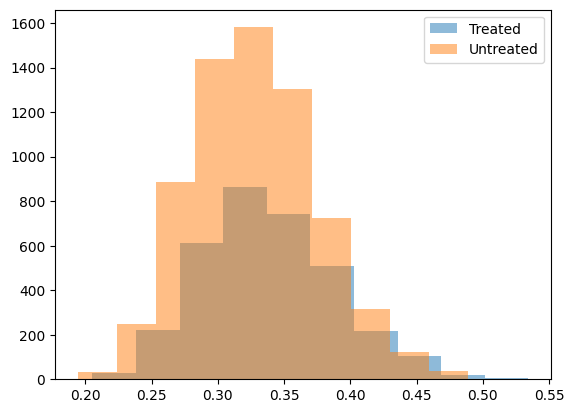

In [12]:
import matplotlib.pyplot as plt
plt.hist(df.loc[df.treatment==1, 'pscore'], alpha=0.5, label='Treated')
plt.hist(df.loc[df.treatment==0, 'pscore'], alpha=0.5, label='Untreated')
plt.legend()
plt.show()


In [13]:
# Mirar la media de churned en tratados vs. no tratados
df.groupby('treatment')['churned'].mean()

treatment
0    0.227375
1    0.194872
Name: churned, dtype: float64